In [2]:
from collections import Counter
from google.colab import drive
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow import keras
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd

import polars as pl
import re

import sklearn as sk
import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

data = pd.read_csv('/content/drive/MyDrive/MIDS DS266 Final Project/code/data/project_data.csv')

Mounted at /content/drive/


<ipython-input-3-d2e7e2a9a170>:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/MIDS DS266 Final Project/code/data/project_data.csv')


# Read & Process Subreddits

In [4]:
subreddit_list = [
    'conspiracy',
    'divorce',
    'fitness',
    'guns',
    'jokes',
    'legaladvice',
    'meditation',
    'parenting',
    'personalfinance',
    'relationships',
    'teaching',
    'mentalhealth',
    'EDAnonymous',
    'addiction',
    'alcoholism',
    'adhd',
    'anxiety',
    'autism',
    'bipolarreddit',
    'bpd',
    'depression',
    'healthanxiety',
    'lonely',
    'ptsd',
    'schizophrenia',
    'socialanxiety',
    'suicidewatch'
]

mental_health_list = [
    'mentalhealth',
    'EDAnonymous',
    'addiction',
    'alcoholism',
    'adhd',
    'anxiety',
    'autism',
    'bipolarreddit',
    'bpd',
    'depression',
    'healthanxiety',
    'lonely',
    'ptsd',
    'schizophrenia',
    'socialanxiety',
    'suicidewatch'
]

# Define a function to read and process a single CSV
def read_and_label_csv(subreddit, time_period):
    df = pl.read_csv(f'/content/drive/MyDrive/MIDS DS266 Final Project/code/data/w266/{subreddit}_{time_period}_features_tfidf_256.csv')
    df = df.select(['subreddit', 'author', 'date', 'post'])
    df = df.with_columns(
        pl.col('date').str.to_datetime('%Y/%m/%d').dt.strftime("%Y-%m"),
        (pl.col('subreddit') == 'suicidewatch').cast(pl.Int64).alias('suicide_risk'),
        (pl.col('subreddit').is_in(mental_health_list)).cast(pl.Int64).alias('mental_health')
    )
    return df

In [5]:
def load_all_data(subreddit_list, time_period):
    all_data = []
    for subreddit in subreddit_list:
        try:
            df = read_and_label_csv(subreddit, time_period)
            all_data.append(df)
        except Exception as e:
            print(f"Error loading {subreddit}: {e}")
    return pl.concat(all_data)


# Analyze Trends & Behaviors
1. total number of entries
2. number of null/empty posts
3. average length of posts (# of words)
4. top 10 most common words in posts
5. number of duplicate entries (author + posts)
6. number of duplicate posts (just posts)
7. number of unique authors

## Method: Top 10 most important words
Process subreddit posts to identify the top 10 most important words for each subreddit using the TF-IDF (Term Frequency-Inverse Document Frequency) method.
* Custom Stop Words: Removes common, uninformative words such as articles and filler words.
* Text Preprocessing: Cleans post text by removing subreddit-specific mentions and URLs.
* TF-IDF Calculation: Scores words based on their relative importance across the posts.
* Support for Bigrams: Includes phrases with two words (e.g., "mental health") in the analysis.

In [6]:
# custom stopwords
custom_stop_words = list(ENGLISH_STOP_WORDS.union({
    "just", "like", "know", "ve", "don", "amp", "time", "did", "said", "want", "one", "people", "would", "com", "www", "https"
}))

# preprocess text and remove subreddit names & URLs
def preprocess_text(text, subreddit):
    if text:
        text = re.sub(rf"\b{subreddit}\b", "", text, flags=re.IGNORECASE)
        text = re.sub(r"https?://\S+|www\.\S+", "", text)
        return text
    return ""

# calculate the top 10 important words for a subreddit
def calculate_tfidf(subreddit, df):
    try:
        # preprocess posts
        df = df.with_columns(
            pl.col("post").map_elements(lambda x: preprocess_text(x, subreddit), return_dtype=pl.Utf8).alias("cleaned_post")
        )

        # extract text for TF-IDF processing
        posts = df.select("cleaned_post").to_series().to_list()

        # vectorizer configuration
        vectorizer = TfidfVectorizer(
            stop_words=custom_stop_words,
            ngram_range=(1, 2),  # include bigrams (two-word phrases)
            sublinear_tf=True,  # sublinear TF-IDF scaling
            max_features=1000  # limit vocab to top 1000 words
        )

        # fit and transform the posts
        tfidf_matrix = vectorizer.fit_transform(posts)
        feature_names = vectorizer.get_feature_names_out()

        # calculate mean TF-IDF scores for each word
        mean_tfidf_scores = tfidf_matrix.mean(axis=0).A1
        word_scores = list(zip(feature_names, mean_tfidf_scores))

        # sort and select the top 10 words
        top_words = sorted(word_scores, key=lambda x: x[1], reverse=True)[:10]

        return top_words

    except Exception as e:
        print(f"Error processing subreddit {subreddit}: {e}")
        return []

# Method: Analyze Subreddit

In [8]:
def analyze_subreddit(df, subreddit):
    print(f"Analysis for Subreddit: {subreddit}")

    # total number of entries
    total_entries = len(df)
    print(f"Total number of entries: {total_entries}")

    # number of null/empty posts
    null_posts = df.filter(pl.col("post").is_null() | (pl.col("post") == "")).height
    print(f"Number of null/empty posts: {null_posts}")

    # average length of posts (# of words)
    df = df.with_columns(pl.col("post").map_elements(lambda x: len(x.split()) if x else 0, return_dtype=pl.Int64).alias("word_count"))
    average_word_count = df.select(pl.col("word_count").mean().alias("average_word_count")).to_series()[0]
    print(f"Average number of words per post: {average_word_count}")

    # top 10 most common words in posts
    df = read_and_label_csv(subreddit, "pre")
    top_words = calculate_tfidf(subreddit, df)
    print(f"\nTop 10 important words for subreddit: {subreddit}")
    for word, score in top_words:
        print(f"{word}: {score:.4f}")

    # number of duplicate entries (author + posts)
    author_post_df = df.select(["author", "post"]).to_pandas()
    duplicate_entries = author_post_df.duplicated(keep=False).sum()  # Count duplicated rows
    print(f"Number of duplicate entries (author + posts): {duplicate_entries}")

    # number of duplicate posts (just posts)
    posts = df["post"].to_list()
    unique_posts = len(set(posts))
    duplicate_posts = len(posts) - unique_posts
    print(f"Number of duplicate posts: {duplicate_posts}")

    # number of unique authors
    df = df.with_columns(pl.col("author").str.strip_chars().str.to_lowercase())
    unique_authors_count = df.select(pl.col("author").unique().count()).item()
    print(f"Number of unique authors: {unique_authors_count}")

    print("\n")

## Analyze 'Pre' Subreddits

In [9]:
# loop through subreddits and analyze
for subreddit in subreddit_list:
    try:
        df = read_and_label_csv(subreddit, "pre")
        analyze_subreddit(df, subreddit)
    except Exception as e:
        print(f"Error loading {subreddit}: {e}")


Analysis for Subreddit: conspiracy
Total number of entries: 12457
Number of null/empty posts: 0
Average number of words per post: 127.56040780284178

Top 10 important words for subreddit: conspiracy
think: 0.0269
epstein: 0.0191
really: 0.0173
world: 0.0173
new: 0.0173
video: 0.0167
going: 0.0167
does: 0.0166
trump: 0.0163
government: 0.0162
Number of duplicate entries (author + posts): 0
Number of duplicate posts: 4
Number of unique authors: 12457


Analysis for Subreddit: divorce
Total number of entries: 6419
Number of null/empty posts: 0
Average number of words per post: 237.3899361271226

Top 10 important words for subreddit: divorce
years: 0.0381
kids: 0.0349
feel: 0.0338
going: 0.0294
wife: 0.0287
married: 0.0274
things: 0.0274
marriage: 0.0271
life: 0.0269
really: 0.0261
Number of duplicate entries (author + posts): 0
Number of duplicate posts: 1
Number of unique authors: 6419


Analysis for Subreddit: fitness
Total number of entries: 22164
Number of null/empty posts: 0
Average 

## Analyze 'Post' Subreddits

In [10]:
# loop through subreddits and analyze
for subreddit in subreddit_list:
    try:
        df = read_and_label_csv(subreddit, "post")
        analyze_subreddit(df, subreddit)
    except Exception as e:
        print(f"Error loading {subreddit}: {e}")


Analysis for Subreddit: conspiracy
Total number of entries: 9933
Number of null/empty posts: 0
Average number of words per post: 127.77942212825934

Top 10 important words for subreddit: conspiracy
think: 0.0269
epstein: 0.0191
really: 0.0173
world: 0.0173
new: 0.0173
video: 0.0167
going: 0.0167
does: 0.0166
trump: 0.0163
government: 0.0162
Number of duplicate entries (author + posts): 0
Number of duplicate posts: 4
Number of unique authors: 12457


Analysis for Subreddit: divorce
Total number of entries: 2747
Number of null/empty posts: 0
Average number of words per post: 231.96214051692755

Top 10 important words for subreddit: divorce
years: 0.0381
kids: 0.0349
feel: 0.0338
going: 0.0294
wife: 0.0287
married: 0.0274
things: 0.0274
marriage: 0.0271
life: 0.0269
really: 0.0261
Number of duplicate entries (author + posts): 0
Number of duplicate posts: 1
Number of unique authors: 6419


Analysis for Subreddit: fitness
Total number of entries: 10029
Number of null/empty posts: 0
Average 

#Overlap of Authors Across Subreddits
* Extract the list of unique authors for each subreddit.
* Compute intersections between these lists to find overlapping authors.
* Represent overlaps visually or numerically.

In [11]:
# Dictionary to store unique authors for each subreddit
authors_per_subreddit = {}

for subreddit in subreddit_list:
    try:
        df = read_and_label_csv(subreddit, "pre")  # Load data
        unique_authors = df.select(pl.col("author").unique()).to_series().to_list()
        authors_per_subreddit[subreddit] = set(unique_authors)
    except Exception as e:
        print(f"Error processing subreddit {subreddit}: {e}")

In [12]:
from itertools import combinations

# Dictionary to store overlap counts
overlap_counts = {}

# Calculate pairwise overlaps
for sub1, sub2 in combinations(subreddit_list, 2):
    overlap = authors_per_subreddit[sub1].intersection(authors_per_subreddit[sub2])
    overlap_counts[(sub1, sub2)] = len(overlap)

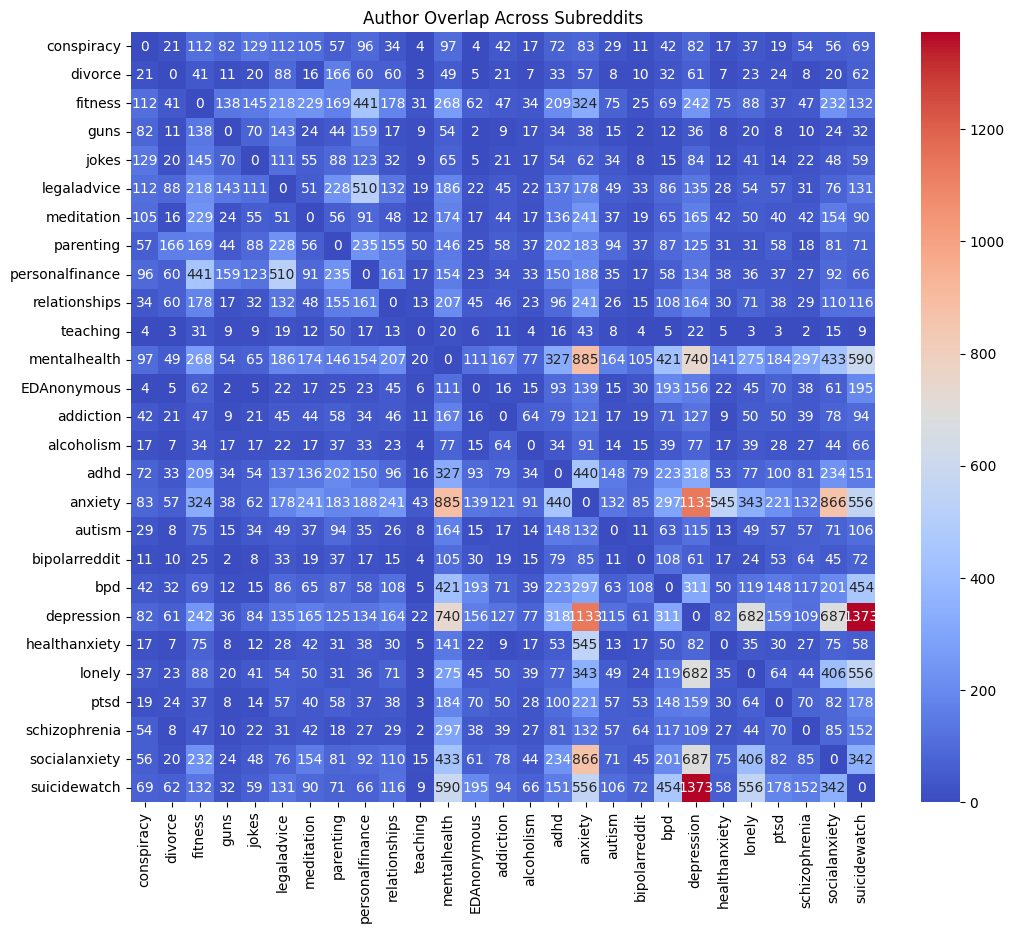

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a matrix for the overlaps
overlap_matrix = pd.DataFrame(index=subreddit_list, columns=subreddit_list, data=0)

for (sub1, sub2), count in overlap_counts.items():
    overlap_matrix.loc[sub1, sub2] = count
    overlap_matrix.loc[sub2, sub1] = count

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(overlap_matrix, annot=True, fmt="d", cmap="coolwarm")
plt.title("Author Overlap Across Subreddits")
plt.show()

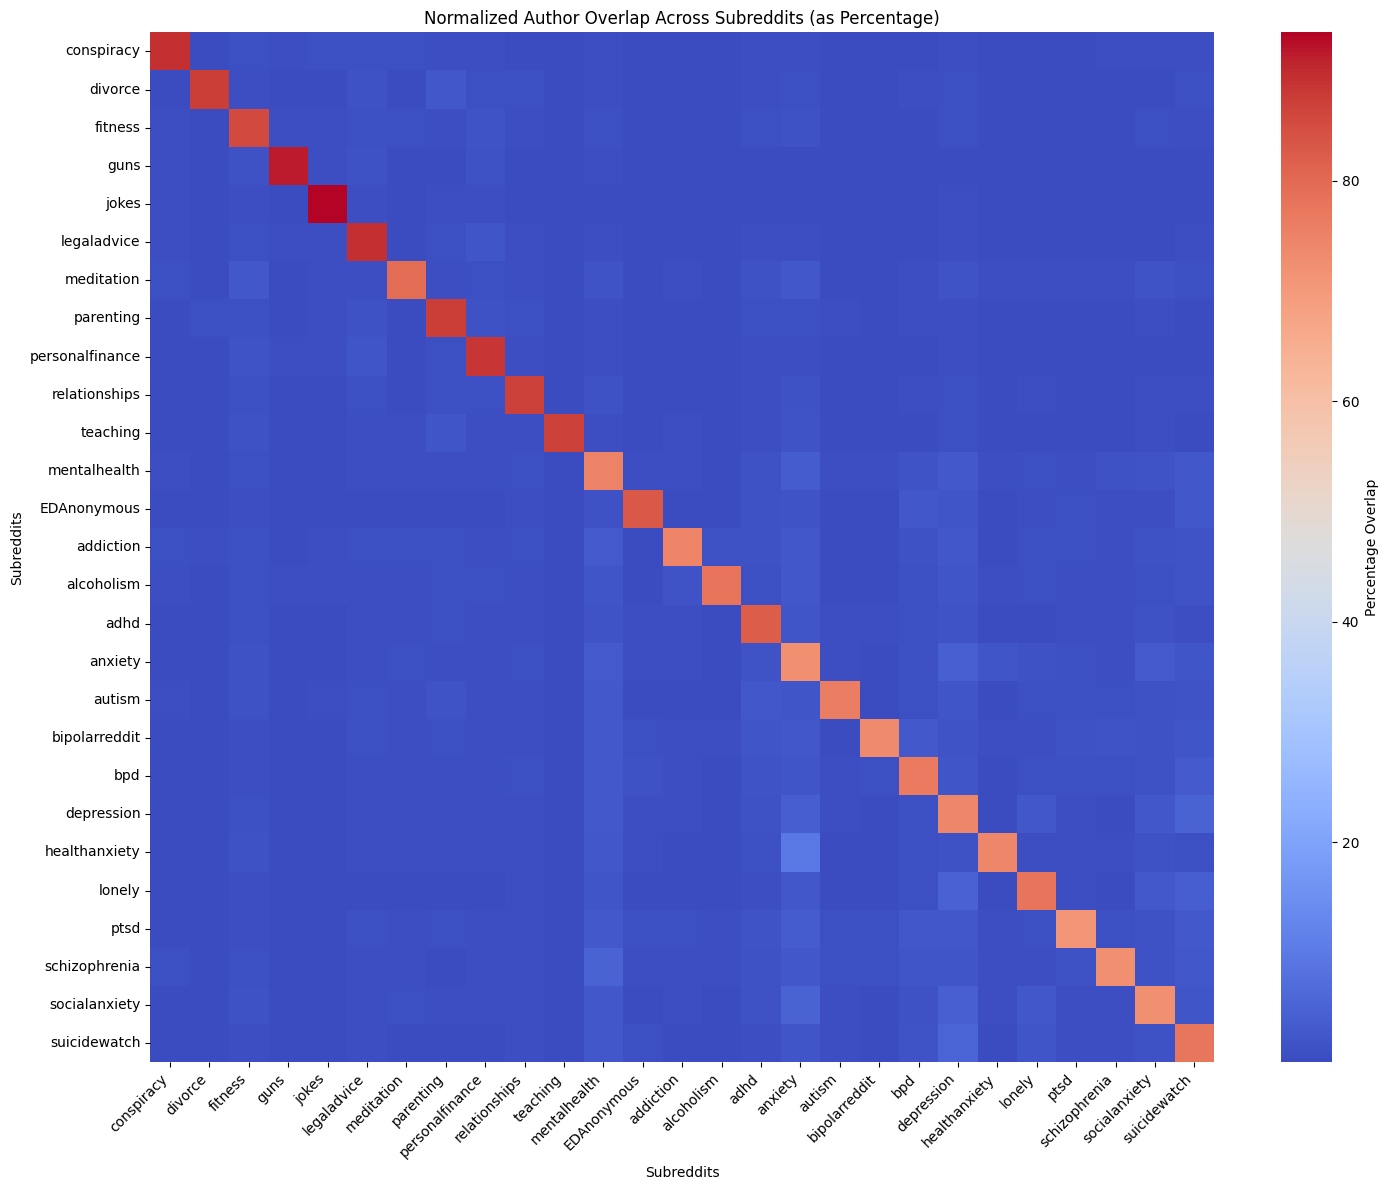

In [18]:
overlap_df = pd.DataFrame(overlap_matrix, index=subreddit_list, columns=subreddit_list)

# Normalizing by row total
normalized_df = overlap_df.div(overlap_df.sum(axis=1), axis=0) * 100

# Plot the normalized heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(
    normalized_df,
    annot=False,
    fmt=".1f",
    cmap="coolwarm",
    cbar_kws={'label': 'Percentage Overlap'},
    xticklabels=subreddit_list,
    yticklabels=subreddit_list
)
plt.title('Normalized Author Overlap Across Subreddits (as Percentage)')
plt.xlabel('Subreddits')
plt.ylabel('Subreddits')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Overlap of Posts Across Subreddits

In [19]:
# Dictionary to store unique posts for each subreddit
posts_per_subreddit = {}

for subreddit in subreddit_list:
    try:
        df = read_and_label_csv(subreddit, "pre")  # Load data
        unique_posts = df.select(pl.col("post").unique()).to_series().to_list()
        posts_per_subreddit[subreddit] = set(unique_posts)
    except Exception as e:
        print(f"Error processing subreddit {subreddit}: {e}")

In [20]:
# Dictionary to store overlap counts
overlap_counts_posts = {}

# Calculate pairwise overlaps
for sub1, sub2 in combinations(subreddit_list, 2):
    overlap_posts = posts_per_subreddit[sub1].intersection(posts_per_subreddit[sub2])
    overlap_counts_posts[(sub1, sub2)] = len(overlap_posts)

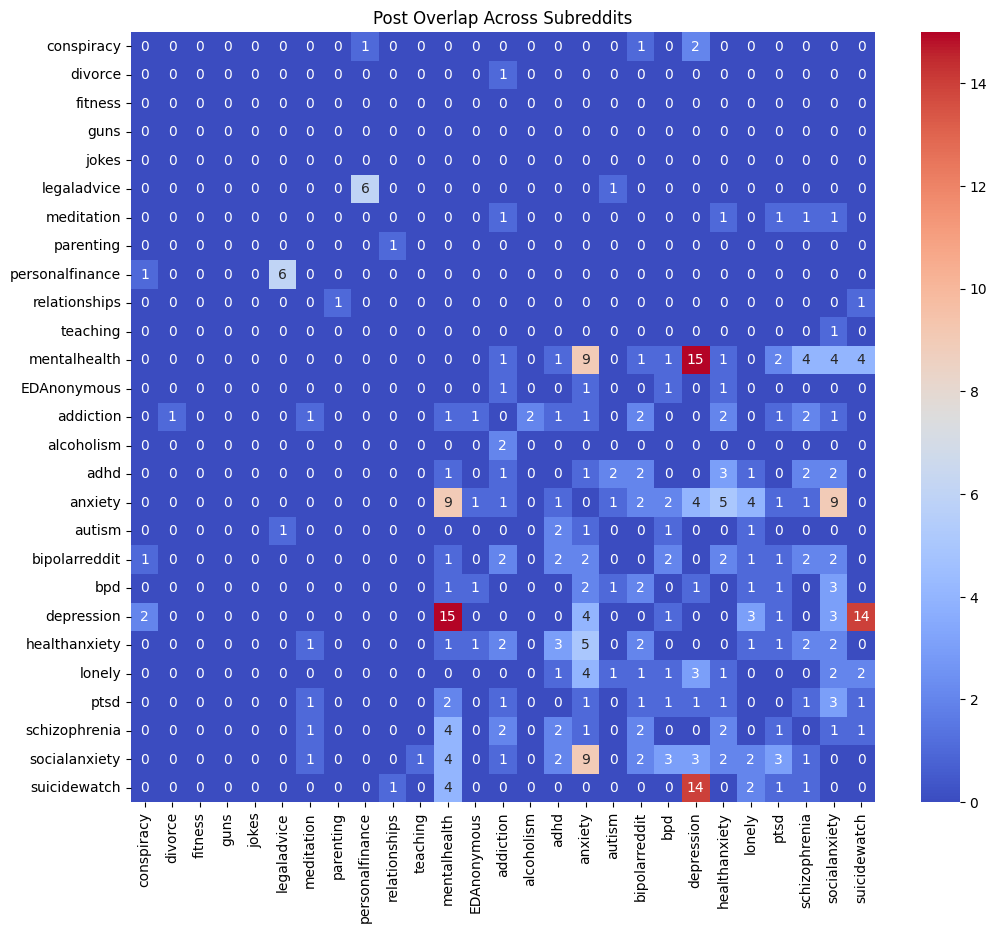

In [22]:
# Create a matrix for the overlaps
overlap_matrix_posts = pd.DataFrame(index=subreddit_list, columns=subreddit_list, data=0)

for (sub1, sub2), count in overlap_counts_posts.items():
    overlap_matrix_posts.loc[sub1, sub2] = count
    overlap_matrix_posts.loc[sub2, sub1] = count

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(overlap_matrix_posts, annot=True, fmt="d", cmap="coolwarm")
plt.title("Post Overlap Across Subreddits")
plt.show()

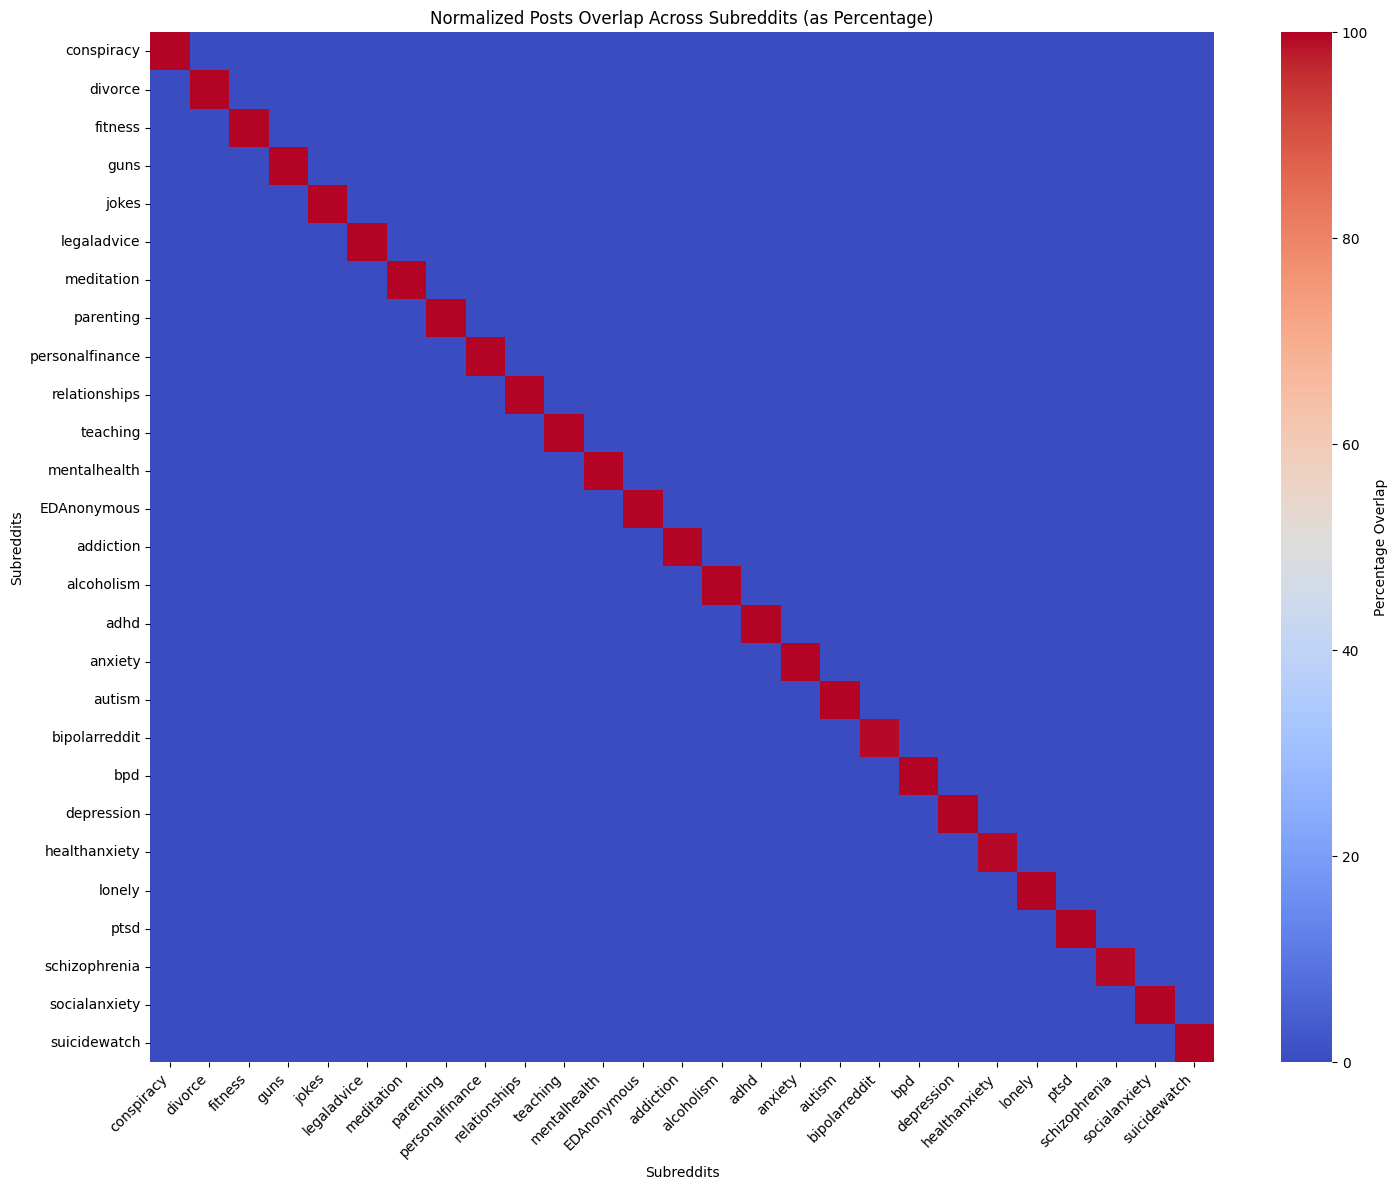

In [25]:
# Create the overlap matrix with absolute counts
overlap_matrix_posts = pd.DataFrame(index=subreddit_list, columns=subreddit_list, data=0)

for (sub1, sub2), count in overlap_counts_posts.items():
    overlap_matrix_posts.loc[sub1, sub2] = count
    overlap_matrix_posts.loc[sub2, sub1] = count

# Add the self-overlap (total unique posts for each subreddit)
for subreddit in subreddit_list:
    overlap_matrix_posts.loc[subreddit, subreddit] = len(posts_per_subreddit[subreddit])

# Normalize by the total unique posts per subreddit
normalized_posts_df = overlap_matrix_posts.div(
    overlap_matrix_posts.sum(axis=1), axis=0
) * 100

# Plot the normalized heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(
    normalized_posts_df,
    annot=False,
    fmt=".1f",
    cmap="coolwarm",
    cbar_kws={'label': 'Percentage Overlap'},
    xticklabels=subreddit_list,
    yticklabels=subreddit_list
)
plt.title('Normalized Posts Overlap Across Subreddits (as Percentage)')
plt.xlabel('Subreddits')
plt.ylabel('Subreddits')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
